<a href="https://colab.research.google.com/github/yunmokoo/SPY-Forecast_MARS_LSTM/blob/main/SPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install requests > make_outputrerquest.txt 2>&1
!pip install yfinance > make_outputyfinance.txt 2>&1
!pip install transformers > make_outputtransformers.txt 2>&1
!pip install xformers > make_outputxformers.txt 2>&1


In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz > wget_output.txt 2>&1
!tar -xzvf ta-lib-0.4.0-src.tar.gz > tar_output.txt 2>&1
%cd ta-lib
!./configure --prefix=/usr > config_output.txt 2>&1
!make > make_outputtalib.txt 2>&1
!make install > makeInstall_output.txt 2>&1
!pip install TA-Lib > pipInstall_output.txt 2>&1

/content/ta-lib


In [2]:
import requests
import json
import yfinance as yf
#import talib

import tensorflow as tf
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from transformers import *
from transformers import GenerationMixin
from transformers import TFGenerationMixin
from transformers import FlaxGenerationMixin

from sklearn.preprocessing import MinMaxScaler

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torch.optim as optim

from transformers import DistilBertTokenizer, DistilBertModel

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` from `src/transformers/generation_flax_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import FlaxGenerationMixin` instead.
  warnings.warn(


From TA-lib...

1. MA                  All Moving Average
2. BBANDS              Bollinger Bands
3. MACD                Moving Average Convergence/Divergence
4. SMA                 Simple Moving Average
5. EMA                 Exponential Moving Average

In [ ]:
data_SPY = yf.download("SPY", start="2001-01-01", end="2023-01-01")
df = pd.DataFrame(data_SPY)

# Step 4: Separate the data into features (input) and target (output)
features = df[['Open', 'High', 'Low', 'Adj Close', 'Volume']].values
target = df[['Close']].values

# Step 5: Data normalization using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler.fit_transform(features)
target_scaled = scaler.fit_transform(target)

# Step 6: Define a function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 10  # You can adjust this value as needed
X, y = create_sequences(target_scaled, sequence_length)

# Step 7: Split the data into train, test, and cross-validation sets
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))
test_size = len(X) - train_size - val_size

X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]
X_test = X[-test_size:]
y_test = y[-test_size:]

# Step 8: Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Step 9: Reshape the input data to fit the LSTM model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Step 10: Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

predicted_scaled = model.predict(X_test)
predicted_close = scaler.inverse_transform(predicted_scaled)
actual_close = scaler.inverse_transform(y_test)

# Step 12: Plot the predicted and actual close values
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(predicted_close):], predicted_close, label='Predicted Close', color='b')
plt.plot(df.index[-len(predicted_close):], actual_close, label='Actual Close', color='g')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Predicted Close vs Actual Close')
plt.legend()



plt.show()

[*********************100%***********************]  1 of 1 completed
Epoch 1/50


KeyboardInterrupt: ignored

In [ ]:
df = pd.DataFrame(yf.download("QQQ", start="2001-01-01", end="2023-01-01"))
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,58.562500,58.687500,52.437500,53.437500,45.814552,62514100
2001-01-03,52.187500,65.250000,52.156250,62.437500,53.530678,118175700
2001-01-04,61.625000,63.625000,60.234375,61.312500,52.566154,58465400
2001-01-05,61.312500,61.312500,56.000000,56.625000,48.547333,68782000
2001-01-08,56.312500,57.500000,53.515625,57.250000,49.083187,55576500
...,...,...,...,...,...,...
2022-12-23,265.470001,268.040009,263.529999,267.359985,266.581055,39373600
2022-12-27,266.739990,266.850006,263.029999,263.579987,262.812073,38009000
2022-12-28,263.170013,265.470001,259.730011,260.100006,259.342224,47139000


In [ ]:
features = df[['Open', 'High','Low']].values

target = df[['Close']].values


scaler = MinMaxScaler()

'''
features_scaled = scaler.fit(features)
print(" \n This is min feature scaling params after .fit \n " + str(scaler.data_min_))
print(" \n This is max feature scaling params after .fit \n " + str(scaler.data_max_))

features_scaled = scaler.transform(features)

target_scaled = scaler.fit(target)

print(" \n This is min target scaling params after .fit \n " + str(scaler.data_min_))
print(" \n This is max target scaling params after .fit \n " + str(scaler.data_max_))

target_scaled = scaler.transform(target)

print("This is features \n" + str(features_scaled))
print("This is target \n" + str(target_scaled))
'''

features_scaled = scaler.fit_transform(features)
target = df[['Close']].values

print(features_scaled)
print(target)


[[0.10015429 0.09829847 0.08535996]
 [0.0836229  0.11520429 0.08462528]
 [0.10809584 0.11101809 0.10572691]
 ...
 [0.63073415 0.63099595 0.62684818]
 [0.63018953 0.63596785 0.63343088]
 [0.63190102 0.63341751 0.63353539]]
[[ 53.4375    ]
 [ 62.4375    ]
 [ 61.3125    ]
 ...
 [260.1000061 ]
 [266.44000244]
 [266.27999878]]


In [ ]:
def initiate_seq(data, target, seq_len):
  X, y = [], []
  for i in range(len(data) - seq_len):
    X.append(data[i:i + seq_len])
    y.append(data[i + seq_len])
  return np.array(X), np.array(y)

seq_len = 10

X, y = initiate_seq(features_scaled, df['Close'].values, seq_len)

In [ ]:
#lets do 60-20-20, train-test-validation respectively

train_size = int(0.6 * len(X))
test_size = int(0.2 * len(X))
val_size = len(X) - train_size - test_size

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:train_size + test_size]
y_test = y[train_size:train_size + test_size]

X_val = X[-val_size:]
y_val = y[-val_size:]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(3315, 10, 3)
(1105, 10, 3)
(1105, 10, 3)


In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(seq_len, 3)))


model.add(Dense(512, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss= 'mse')



testing from here


In [ ]:
'''
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 3))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 3))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 3))

y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
'''

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)



predicted_scaled = model.predict(X_test)
predicted_close = scaler.inverse_transform(predicted_scaled)
actual_close = scaler.inverse_transform(y_test)


plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(predicted_close):], predicted_close, label='Predicted Close', color='b')
plt.plot(df.index[-len(predicted_close):], actual_close, label='Actual Close', color='g')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Predicted Close vs Actual Close')
plt.legend()


plt.show()


ValueError: ignored

# Transformer


In [ ]:
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df_normalized

,Open,High,Low,Close,Adj Close,Volume
0,0.155737,0.151608,0.147845,0.148199,0.079748,0.006263
1,0.146771,0.160983,0.148074,0.163306,0.089547,0.018587
2,0.162880,0.159688,0.161140,0.159758,0.087246,0.006818
3,0.159308,0.155190,0.151818,0.149115,0.080342,0.011073
4,0.150570,0.146806,0.148150,0.151556,0.081925,0.003829
...,...,...,...,...,...,...
5530,0.757896,0.763598,0.760294,0.768555,0.791514,0.065175
5531,0.765531,0.763818,0.764256,0.764868,0.787902,0.055703
5532,0.761981,0.764403,0.756358,0.753296,0.776566,0.077915
5533,0.757848,0.766745,0.762862,0.769849,0.792781,0.073373


In [ ]:
print(X)
print(y)

[[[0.10015429 0.09829847 0.08535996]
  [0.0836229  0.11520429 0.08462528]
  [0.10809584 0.11101809 0.10572691]
  ...
  [0.1019776  0.11117909 0.10299227]
  [0.11101314 0.11359421 0.10903297]
  [0.11052693 0.10920675 0.10658404]]

 [[0.0836229  0.11520429 0.08462528]
  [0.10809584 0.11101809 0.10572691]
  [0.10728548 0.1050608  0.0946659 ]
  ...
  [0.11101314 0.11359421 0.10903297]
  [0.11052693 0.10920675 0.10658404]
  [0.11555117 0.11613008 0.1133186 ]]

 [[0.10809584 0.11101809 0.10572691]
  [0.10728548 0.1050608  0.0946659 ]
  [0.09431968 0.09523932 0.08817623]
  ...
  [0.11052693 0.10920675 0.10658404]
  [0.11555117 0.11613008 0.1133186 ]
  [0.11457874 0.11906847 0.11213495]]

 ...

 [[0.71755307 0.71191203 0.69523539]
  [0.69525188 0.69782062 0.68813022]
  [0.68041901 0.67618119 0.66848655]
  ...
  [0.6494308  0.64397964 0.63397942]
  [0.63669838 0.63761661 0.63677448]
  [0.63999166 0.63455101 0.63546839]]

 [[0.69525188 0.69782062 0.68813022]
  [0.68041901 0.67618119 0.66848655]


[*********************100%***********************]  1 of 1 completed
Epoch 1/50
104/104 [==============================] - 4s 10ms/step - loss: 7.4426e-04 - val_loss: 0.0788
Epoch 2/50
104/104 [==============================] - 1s 6ms/step - loss: 7.2448e-06 - val_loss: 0.0791
Epoch 3/50
104/104 [==============================] - 1s 6ms/step - loss: 8.0363e-06 - val_loss: 0.0780
Epoch 4/50
104/104 [==============================] - 1s 7ms/step - loss: 1.1694e-05 - val_loss: 0.0778
Epoch 5/50
104/104 [==============================] - 1s 6ms/step - loss: 7.5928e-06 - val_loss: 0.0797
Epoch 6/50
104/104 [==============================] - 1s 8ms/step - loss: 7.5342e-06 - val_loss: 0.0720
Epoch 7/50
104/104 [==============================] - 1s 9ms/step - loss: 7.1793e-06 - val_loss: 0.0719
Epoch 8/50
104/104 [==============================] - 1s 10ms/step - loss: 9.3852e-06 - val_loss: 0.0718
Epoch 9/50
104/104 [==============================] - 1s 10ms/step - loss: 8.6165e-06 - val_loss:

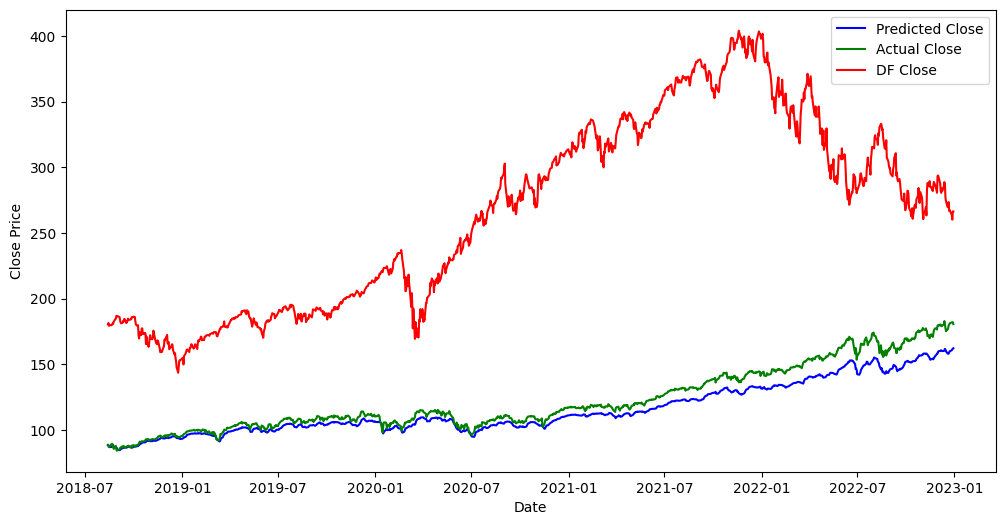

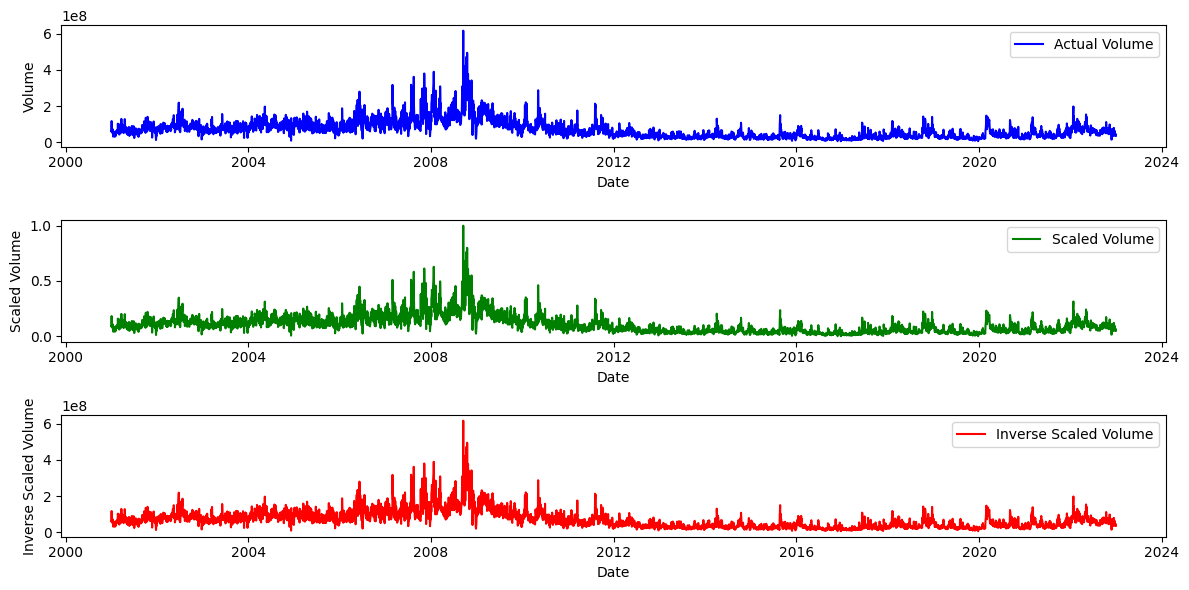

In [14]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Download historical stock data and create DataFrame
df = pd.DataFrame(yf.download("QQQ", start="2001-01-01", end="2023-01-01"))
features = df['Volume']
target = df['Close']

# Feature scaling
scaler = MinMaxScaler()

features_scaled = scaler.fit_transform(target.values.reshape(-1, 1))
target_scaled = scaler.fit_transform(target.values.reshape(-1, 1))

#dumb
volume_scaler = MinMaxScaler()
volume_scaled = volume_scaler.fit_transform(features.values.reshape(-1, 1))

def initiate_seq(data, target, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(target[i + seq_len])
    return np.array(X), np.array(y)



# Data split
train_size = int(0.6 * len(X))
test_size = int(0.2 * len(X))
val_size = len(X) - train_size - test_size

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:train_size + test_size]
y_test = y[train_size:train_size + test_size]

X_val = X[-val_size:]
y_val = y[-val_size:]

# LSTM model
model = Sequential()
model.add(LSTM(5, input_shape=(seq_len, 1)))  # 3 input features: Open, High, Low

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Model training
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Prediction and inverse scaling
predicted_scaled = model.predict(X_test)
predicted_close = scaler.inverse_transform(predicted_scaled)
actual_close = scaler.inverse_transform(y_test)


# Plotting the predicted vs actual close prices
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(predicted_close):], predicted_close[:, 0], label='Predicted Close', color='b')
plt.plot(df.index[-len(predicted_close):], actual_close[:, 0], label='Actual Close', color='g')
plt.plot(df.index[-len(actual_close):], df['Close'][-len(actual_close):], label='DF Close', color='r')  # Adding the DF Close data
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Plotting the actual, scaled, and inverse-scaled feature values
plt.figure(figsize=(12, 6))

# Plotting the actual feature value
plt.subplot(3, 1, 1)
plt.plot(df.index[-len(features):], features.values[-len(features):], label='Actual Volume', color='b')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()

# Plotting the scaled feature value
plt.subplot(3, 1, 2)
plt.plot(df.index[-len(volume_scaled):], volume_scaled[:, 0], label='Scaled Volume', color='g')
plt.xlabel('Date')
plt.ylabel('Scaled Volume')
plt.legend()

# Inverse scaling the feature value
inverse_scaled_volume = volume_scaler.inverse_transform(volume_scaled)
plt.subplot(3, 1, 3)
plt.plot(df.index[-len(features):], inverse_scaled_volume[-len(features):], label='Inverse Scaled Volume', color='r')
plt.xlabel('Date')
plt.ylabel('Inverse Scaled Volume')
plt.legend()

plt.tight_layout()
plt.show()

# 7/31


[*********************100%***********************]  1 of 1 completed
Epoch 1/50
104/104 [==============================] - 6s 12ms/step - loss: 4.0478e-04 - val_loss: 0.0093
Epoch 2/50
104/104 [==============================] - 1s 8ms/step - loss: 1.1518e-05 - val_loss: 0.0078
Epoch 3/50
104/104 [==============================] - 1s 7ms/step - loss: 1.0335e-05 - val_loss: 0.0045
Epoch 4/50
104/104 [==============================] - 1s 7ms/step - loss: 1.1705e-05 - val_loss: 0.0055
Epoch 5/50
104/104 [==============================] - 1s 7ms/step - loss: 1.0482e-05 - val_loss: 0.0058
Epoch 6/50
104/104 [==============================] - 1s 7ms/step - loss: 1.1521e-05 - val_loss: 0.0048
Epoch 7/50
104/104 [==============================] - 1s 7ms/step - loss: 1.0671e-05 - val_loss: 0.0035
Epoch 8/50
104/104 [==============================] - 1s 7ms/step - loss: 1.0072e-05 - val_loss: 0.0031
Epoch 9/50
104/104 [==============================] - 1s 8ms/step - loss: 1.2688e-05 - val_loss: 0

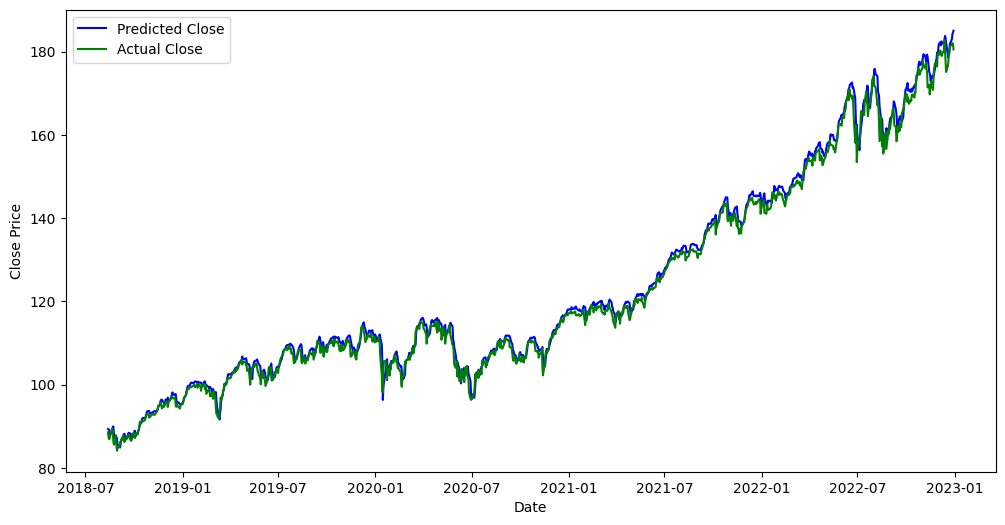

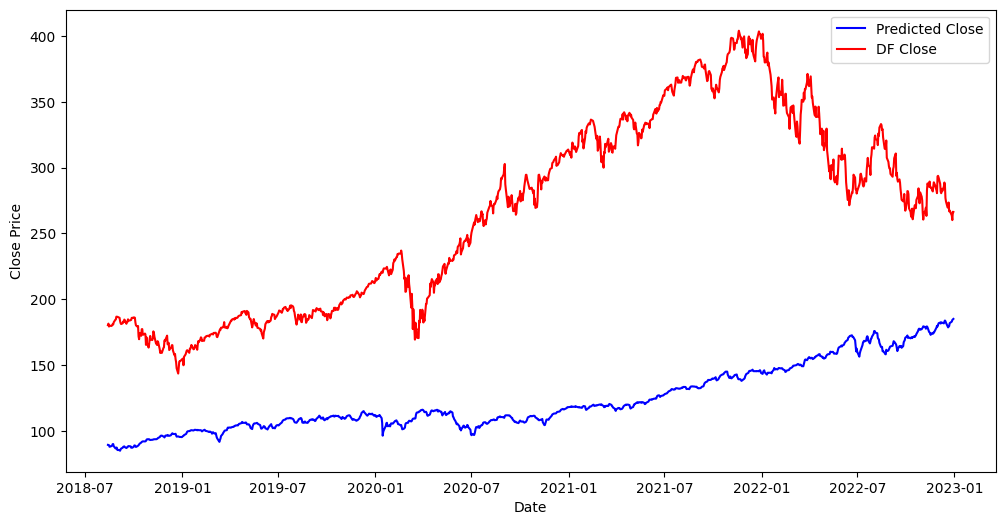

In [61]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Download historical stock data and create DataFrame
df = pd.DataFrame(yf.download("QQQ", start="2001-01-01", end="2023-01-01"))
features = df[['Open', 'High', 'Low', 'Volume']]
target = df['Close']



scaler = MinMaxScaler()

# Feature scaling

features_scaled = scaler.fit_transform(features)


target_scaled = scaler.fit_transform(target.values.reshape(-1, 1))




def initiate_seq(data, target, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(target[i + seq_len])
    return np.array(X), np.array(y)

seq_len = 10

X, y = initiate_seq(features_scaled, target_scaled, seq_len)
#X, y = initiate_seq(features, target, seq_len)





# Data split
train_size = int(0.6 * len(X))
test_size = int(0.2 * len(X))
val_size = len(X) - train_size - test_size

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:train_size + test_size]
y_test = y[train_size:train_size + test_size]

X_val = X[-val_size:]
y_val = y[-val_size:]




# LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(seq_len, 4)))  # 4 input features: Open, High, Low

model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# Model training
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Prediction and inverse scaling

predicted_scaled = model.predict(X_test)
predicted_close = scaler.inverse_transform(predicted_scaled)
print("Minimum:", scaler.data_min_)
print("Maximum:", scaler.data_max_)

actual_close = scaler.inverse_transform(y_test)



# Plotting the predicted vs actual close prices
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(predicted_close):], predicted_close[:, 0], label='Predicted Close', color='b')
plt.plot(df.index[-len(predicted_close):], actual_close[:, 0], label='Actual Close', color='g')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Plot predicted and raw df
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(predicted_close):], predicted_close[:, 0], label='Predicted Close', color='b')
plt.plot(df.index[-len(actual_close):], df['Close'][-len(actual_close):], label='DF Close', color='r')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [34]:
# Check if actual_close and df['Close'] are the same
print(np.allclose(actual_close, df['Close'][-len(actual_close):].values))

False


In [35]:
print("Actual Close:", actual_close[:5])
print("DF Close:", df['Close'][-len(actual_close):].values[:5])

Actual Close: [[88.51000214]
 [87.37000275]
 [86.87999725]
 [87.05000305]
 [87.66999817]]
DF Close: [180.32000732 181.44999695 179.22999573 179.82000732 179.86000061]


In [39]:
print(features_scaled)
feature_inverse = scaler.inverse_transform(features_scaled)
print(feature_inverse)
print(features)

[[0.10015429 0.09829847 0.08535996 0.09092248]
 [0.0836229  0.11520429 0.08462528 0.18221695]
 [0.10809584 0.11101809 0.10572691 0.08428193]
 ...
 [0.63073415 0.63099595 0.62684818 0.06570471]
 [0.63018953 0.63596785 0.63343088 0.06366204]
 [0.63190102 0.63341751 0.63353539 0.05048278]]
[[ 58.51223503  57.79973028  52.83224917  54.96786663]
 [ 52.16533866  64.29038056  52.55018368  90.01855209]
 [ 61.56123427  62.68317192  60.65173158  52.41835834]
 ...
 [262.21775421 262.31826723 260.72581447  45.28600707]
 [262.0086581  264.22712932 263.25311031  44.5017658 ]
 [262.66575219 263.24797803 263.29323487  39.44185425]]
                  Open        High         Low     Volume
Date                                                     
2001-01-02   58.562500   58.687500   52.437500   62514100
2001-01-03   52.187500   65.250000   52.156250  118175700
2001-01-04   61.625000   63.625000   60.234375   58465400
2001-01-05   61.312500   61.312500   56.000000   68782000
2001-01-08   56.312500   57.

In [59]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Download historical stock data and create DataFrame
df = pd.DataFrame(yf.download("QQQ", start="2001-01-01", end="2023-01-01"))
features = df[['Open', 'High', 'Low', 'Volume']]
target = df['Close']



scaler = MinMaxScaler()

# Feature scaling

features_scaled = scaler.fit_transform(features)
print("Minimum:", scaler.data_min_)
print("Maximum:", scaler.data_max_)

target_scaled = scaler.fit_transform(target.values.reshape(-1, 1))
print("Minimum:", scaler.data_min_)
print("Maximum:", scaler.data_max_)



def initiate_seq(data, target, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(target[i + seq_len])
    return np.array(X), np.array(y)

seq_len = 10

X, y = initiate_seq(features_scaled, target_scaled, seq_len)
#X, y = initiate_seq(features, target, seq_len)


[*********************100%***********************]  1 of 1 completed
Minimum: [1.99400005e+01 2.05300007e+01 1.97600002e+01 7.07930000e+06]
Maximum: [4.05570007e+02 4.08709991e+02 4.02579987e+02 6.16772300e+08]
Minimum: [20.05999947]
Maximum: [403.98999023]


the target data config was used for inversing transform for test data.